In [11]:
import os
import sys

import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
from itertools import product

import scvi

SCRIPT_DIR = os.path.dirname(os.getcwd())
SCRIPT_DIR += '/src/inVAE'
sys.path.append(os.path.dirname(SCRIPT_DIR))
from inVAE.utils import sparse_shift, mcc, get_linear_score
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
sys.path.append('../')
from src.inVAE.model import FinVAE

In [13]:
n_batches = 3
n_cell_types = 2
n_disease_states = 2
n_cells_per_comb = 500
#n_chem: int = 100
n_latent_inv = 8
n_latent_spur = 2
n_genes = 100

# Use defaults or params?
shift_cell_type = [5, 2]
shift_disease = [0, 1]
var_batch = [1, 2, 3]

In [482]:
#     conditions = 1
#     celltypes = 2
#     batches = 3
#     n_cells_per_comb = 100
#     n_latents = 5
#     n_genes = 100
#     ct_means = [[1.,1.2,1.3],[3.77,-0.5,7.4]]
#     bmeans = [[1.1,0.8],[7.5,0.],[0.0,12.]]#[10.9,12.3],[20.9,22.3]]
#     cond_shift = [[0.,0.,3.2],[6.7,0.9,0.],[6.7,0.9,0.]]#[2,2,2,2,2,2,2,2],[3,3,3,3,3,3,3,3]]
#     var_tmp = np.eye(n_latents) #[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
#     var_tmp[8:,8:]=0
#     z = np.zeros((batches * conditions * celltypes * n_cells_per_comb, n_latents))
#     obs = np.zeros((batches * conditions * celltypes * n_cells_per_comb,3))
#     obs_df = pd.DataFrame(obs,columns=['batch','cell_type','disease'])
    
#     tmp = 0
#     for cond in range(batches):
#         #generate 100 cells for each cell type:
#         for cell in range(celltypes):
#             inv = list(np.array(ct_means[cell]))#+np.array(cond_shift[cond]))
#             spur = bmeans[0]
#             print(inv+spur)
#             z[
#                 (tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb) 
#             ] = np.random.multivariate_normal(
#                 inv+spur, var_tmp, size=(n_cells_per_comb)
#             )
            
#             obs_df.iloc[(tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb),0] = cond
#             obs_df.iloc[(tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb),1] = cell
#             obs_df.iloc[(tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb),2] = cond
            
#             tmp+=1
    
#     # finally, get the decoder, and get gene expression x for the cells
#     params = _prepare_params_decoder(n_genes, n_latents)
#     x = _decoder(z, params=params)
#     x = np.random.poisson(lam=1e6 * x)
    
#     # shuffle dataset
#     ind = np.random.permutation(np.arange(obs_df.shape[0]))

#     # dump into anndata
#     adata = AnnData(x, dtype=np.float32)
#     adata.obs = obs_df
#     adata.obsm["groundtruth_latent"] = z
#     print(z[:,8:])
#     #adata.uns["prior_mean"] = action_specific_prior_mean
#     adata = adata[ind]
#     return adata

IndentationError: unexpected indent (1778544708.py, line 2)

In [517]:
from typing import List
from itertools import product

import numpy as np
import pandas as pd
from anndata import AnnData

from scipy.stats import spearmanr
from scipy.optimize import linear_sum_assignment
from sklearn.linear_model import LinearRegression

def get_linear_score(x, y):
    reg = LinearRegression().fit(x, y)
    return reg.score(x, y)

def mcc(x, y, method='pearson'):
    """
    A numpy implementation of the mean correlation coefficient metric.
    :param x: numpy.ndarray
    :param y: numpy.ndarray
    :param method: str, optional
            The method used to compute the correlation coefficients.
                The options are 'pearson' and 'spearman'
                'pearson':
                    use Pearson's correlation coefficient
                'spearman':
                    use Spearman's nonparametric rank correlation coefficient
    :return: float
    """
    
    d = x.shape[1]
    if method == 'pearson':
        cc = np.corrcoef(x, y, rowvar=False)[:d, d:]
    elif method == 'spearman':
        cc = spearmanr(x, y)[0][:d, d:]
    else:
        raise ValueError('not a valid method: {}'.format(method))
        
    cc = np.abs(cc)
    score = cc[linear_sum_assignment(-1 * cc)].mean()
    return score

# code adapted from lachapelle et al. (their code assumes x_dim = z_dim = h_dim)
def _prepare_params_decoder(x_dim, z_dim, h_dim=40, neg_slope=0.2):
    if z_dim > h_dim or h_dim > x_dim:
        raise ValueError("CHECK dim <= h_dim <= x_dim")
    # sampling NN weight matrices
    W1 = np.random.normal(size=(z_dim, h_dim))
    W1 = np.linalg.qr(W1.T)[0].T
    W1 *= np.sqrt(2 / (1 + neg_slope**2)) * np.sqrt(2.0 / (z_dim + h_dim))

    W2 = np.random.normal(size=(h_dim, h_dim))
    W2 = np.linalg.qr(W2.T)[0].T
    # print("distance to identity:", np.max(np.abs(np.matmul(W2, W2.T) - np.eye(h_dim)))
    W2 *= np.sqrt(2 / (1 + neg_slope**2)) * np.sqrt(2.0 / (2 * h_dim))

    W3 = np.random.normal(size=(h_dim, h_dim))
    W3 = np.linalg.qr(W3.T)[0].T
    # print("distance to identity:", np.max(np.abs(np.matmul(W3, W3.T) - np.eye(h_dim))))
    W3 *= np.sqrt(2 / (1 + neg_slope**2)) * np.sqrt(2.0 / (2 * h_dim))

    W4 = np.random.normal(size=(h_dim, x_dim))
    W4 = np.linalg.qr(W4.T)[0].T
    # print("distance to identity:", np.max(np.abs(np.matmul(W4, W4.T) - np.eye(h_dim))))
    W4 *= np.sqrt(2 / (1 + neg_slope**2)) * np.sqrt(2.0 / (x_dim + h_dim))
    return {"W1": W1, "W2": W2, "W3": W3, "W4": W4}


def _decoder(z, params, neg_slope=0.2):
    W1, W2, W3, W4 = params["W1"], params["W2"], params["W3"], params["W4"]
    # note that this decoder is almost surely invertible WHEN dim <= h_dim <= x_dim
    # since Wx is injective
    # when columns are linearly indep, which happens almost surely,
    # plus, composition of injective functions is injective.
    h1 = np.matmul(z, W1)
    h1 = np.maximum(neg_slope * h1, h1)  # leaky relu
    h2 = np.matmul(h1, W2)
    h2 = np.maximum(neg_slope * h2, h2)  # leaky relu
    h3 = np.matmul(h2, W3)
    h3 = np.maximum(neg_slope * h3, h3)  # leaky relu
    logits = np.matmul(h3, W4)
    logits /= np.std(logits)
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)


def sparse_shift():
    
    conditions = 1
    celltypes = 2
    batches = 3
    n_cells_per_comb = 100
    n_latents = 5
    n_genes = 100
    ct_means = [[1.,1.2,1.3],[3.77,-0.5,7.4]]
    bmeans = [[1.1,0.8],[7.5,0.],[0.0,12.]]#[10.9,12.3],[20.9,22.3]]
    cond_shift = [[0.,0.,3.2],[6.7,0.9,0.],[6.7,0.9,0.]]#[2,2,2,2,2,2,2,2],[3,3,3,3,3,3,3,3]]
    var_tmp = np.eye(n_latents) #[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
    var_tmp[8:,8:]=0
    z = np.zeros((batches * conditions * celltypes * n_cells_per_comb, n_latents))
    obs = np.zeros((batches * conditions * celltypes * n_cells_per_comb,3))
    obs_df = pd.DataFrame(obs,columns=['batch','cell_type','disease'])
    
    tmp = 0
    for cond in range(batches):
        #generate 100 cells for each cell type:
        for cell in range(celltypes):
            inv = list(np.array(ct_means[cell])+np.array(cond_shift[cond]))
            spur = bmeans[0]
            print(inv+spur)
            z[
                (tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb) 
            ] = np.random.multivariate_normal(
                inv+spur, var_tmp, size=(n_cells_per_comb)
            )
            
            obs_df.iloc[(tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb),0] = 0
            obs_df.iloc[(tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb),1] = cell
            obs_df.iloc[(tmp * n_cells_per_comb) : ((tmp+1) * n_cells_per_comb),2] = cond
            
            tmp+=1
    
    # finally, get the decoder, and get gene expression x for the cells
    params = _prepare_params_decoder(n_genes, n_latents)
    x = _decoder(z, params=params)
    x = np.random.poisson(lam=1e6 * x)
    
    # shuffle dataset
    ind = np.random.permutation(np.arange(obs_df.shape[0]))

    # dump into anndata
    adata = AnnData(x, dtype=np.float32)
    adata.obs = obs_df
    adata.obsm["groundtruth_latent"] = z
    print(z[:,8:])
    #adata.uns["prior_mean"] = action_specific_prior_mean
    adata = adata[ind]
    return adata


In [518]:
adata = sparse_shift()

[1.0, 1.2, 4.5, 1.1, 0.8]
[3.77, -0.5, 10.600000000000001, 1.1, 0.8]
[7.7, 2.1, 1.3, 1.1, 0.8]
[10.47, 0.4, 7.4, 1.1, 0.8]
[7.7, 2.1, 1.3, 1.1, 0.8]
[10.47, 0.4, 7.4, 1.1, 0.8]
[]


In [519]:
# adata = sparse_shift(
#     n_cells_per_comb = 500,
#     n_batches = 3,
#     n_cell_types = 2,
#     n_disease_states = 3,
#     n_latent_inv = 8,
#     n_latent_spur = 2,
#     n_genes = 100,
#     shift_cell_type = [20., 100.],
#     shift_disease = [0., 1.1, 1.3],
#     mean_batch= [0.,1.,5.0],#, 6., 9.],
#     var_batch = [1.,1.0,1.]#, 2., 1.0]
# )

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


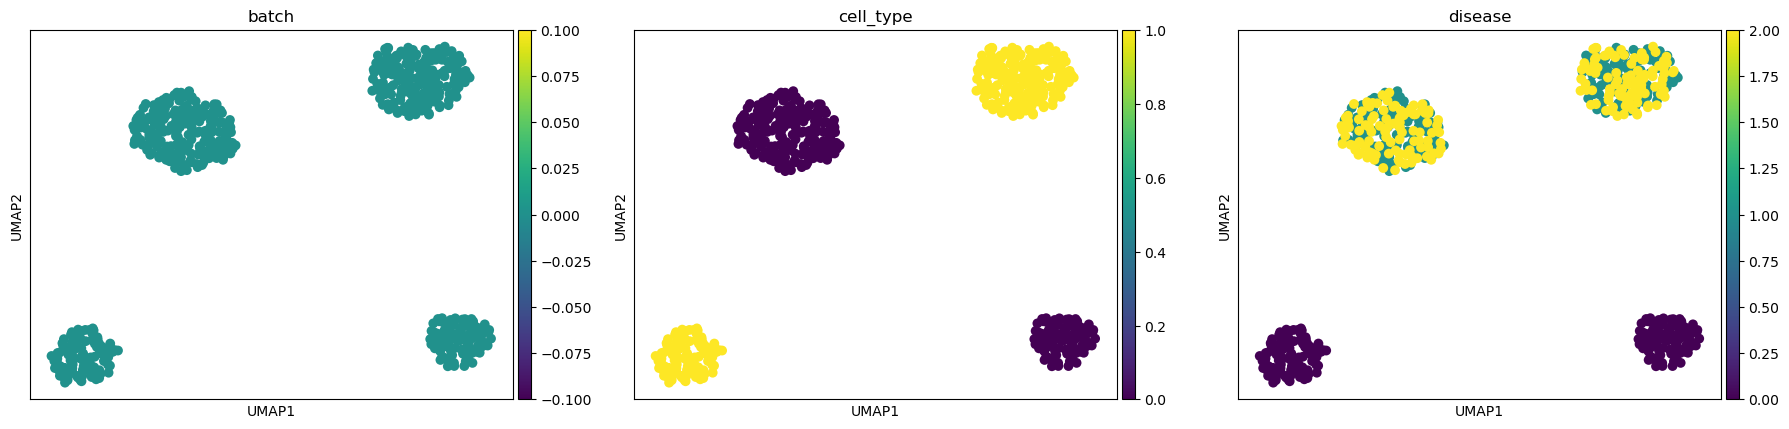

In [520]:
sc.pp.neighbors(adata, use_rep='groundtruth_latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

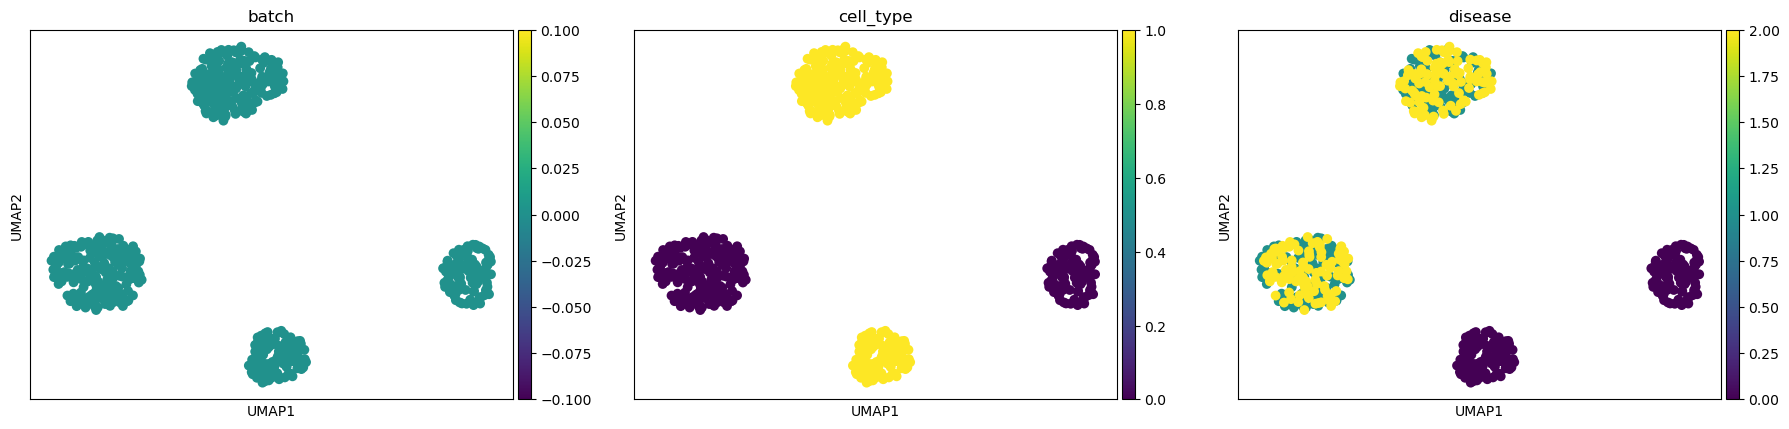

In [521]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

In [522]:
adata.obsm['groundtruth_latent_inv'] = adata.obsm['groundtruth_latent'][:,:3]
adata.obsm['groundtruth_latent_spur'] = adata.obsm['groundtruth_latent'][:,3:]

In [523]:
adata

AnnData object with n_obs × n_vars = 600 × 100
    obs: 'batch', 'cell_type', 'disease'
    uns: 'neighbors', 'umap'
    obsm: 'groundtruth_latent', 'X_umap', 'groundtruth_latent_inv', 'groundtruth_latent_spur'
    obsp: 'distances', 'connectivities'

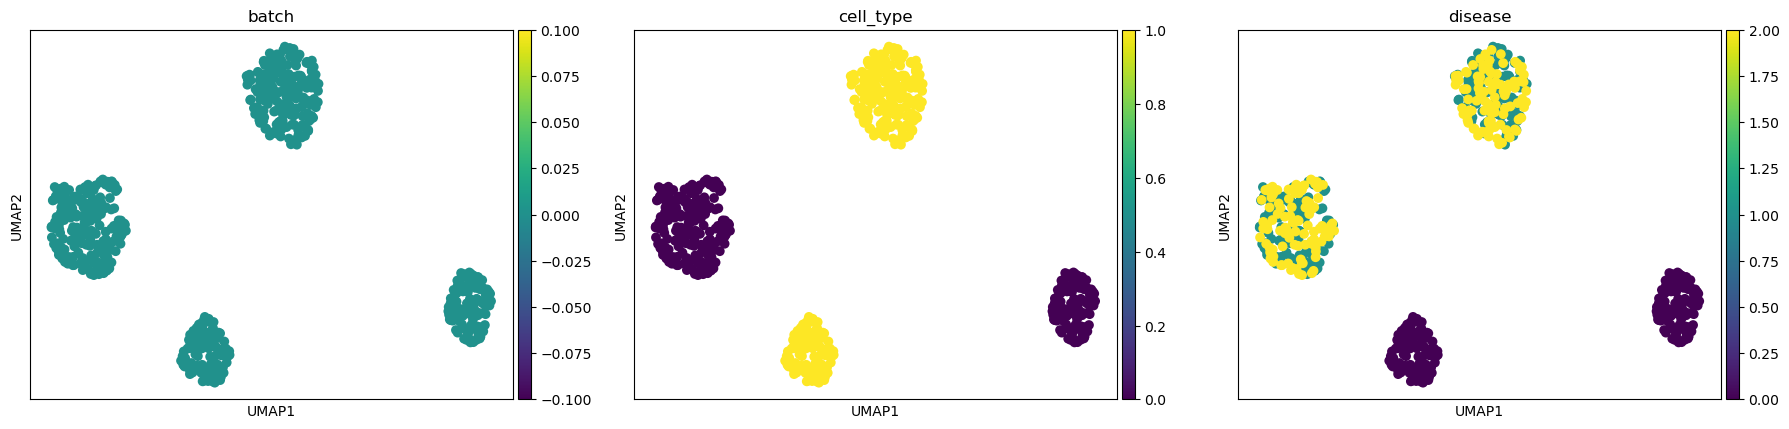

In [524]:
sc.pp.neighbors(adata, use_rep='groundtruth_latent_inv')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

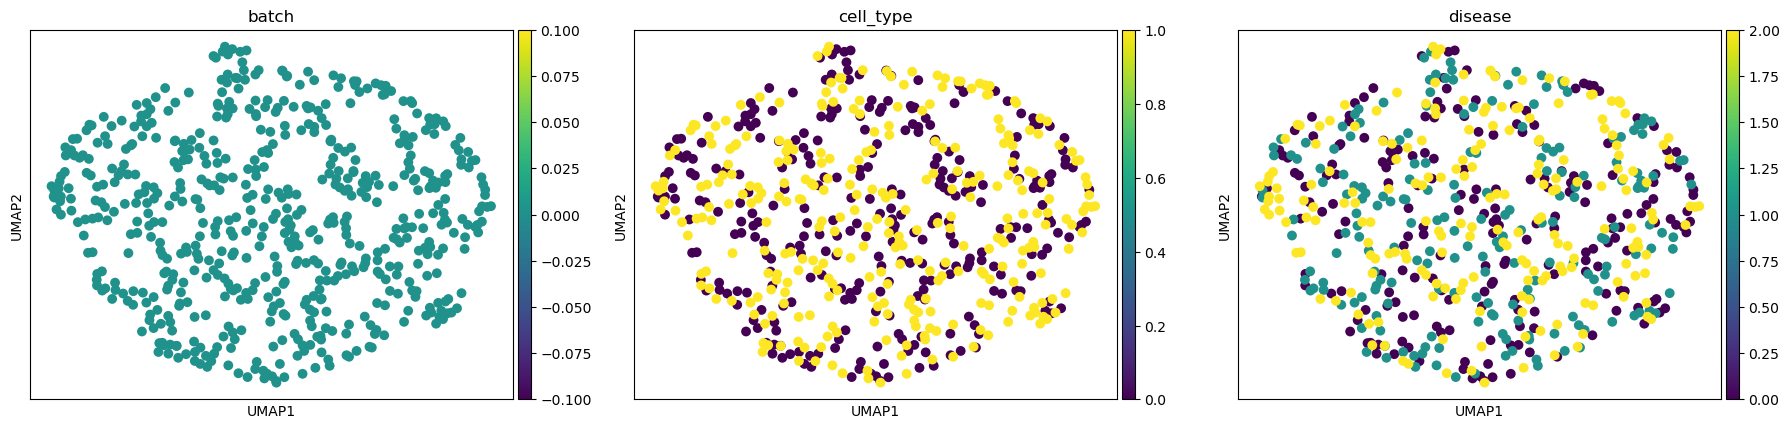

In [525]:
sc.pp.neighbors(adata, use_rep='groundtruth_latent_spur')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

In [526]:
import matplotlib.pyplot as plt

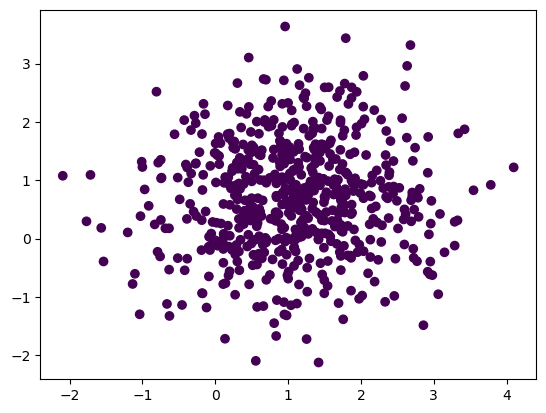

In [527]:
plt.scatter(adata.obsm['groundtruth_latent_spur'][:,0], adata.obsm['groundtruth_latent_spur'][:,1], c = adata.obs['batch'])

Numbers:

mean = (mean_cell_type + mean_disease, mean_batch)



In [528]:
#from inVAE import FinVAE

In [529]:
adata.layers['raw'] = adata.X.copy()
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

In [530]:
adata.obs.batch = adata.obs.batch.astype(str)
adata.obs.cell_type = adata.obs.cell_type.astype(str)
adata.obs.disease = adata.obs.disease.astype(str)

In [541]:
inv_covar_keys = {
    'cont': [],
    'cat': ['cell_type','disease'] #set to the keys in the adata
}

spur_covar_keys = {
    'cont': [],
    'cat': ['batch'] #set to the keys in the adata
}

model = FinVAE(
    adata = adata,
    layer = None, # The layer where the raw counts are stored in adata (None for adata.X: default)
    latent_dim_inv=3,
    latent_dim_spur=2,
    hidden_dim = 128,
    inv_covar_keys = inv_covar_keys,
    spur_covar_keys = spur_covar_keys,
    kl_rate = 1,
    elbo_version='sample'
)

model.train(n_epochs = 3000, lr_train=0.001, weight_decay=0.0001)

Layer is None, check if you want to specify the layer of adata!
Data loading done!
Defaulting to printing training loss every 600 epochs. If you want a different number, set it for the train function!
Starting training of model:
	epoch 600/3000 took 0.02s; loss: 764.05
	epoch 1200/3000 took 0.02s; loss: 693.89
	epoch 1800/3000 took 0.02s; loss: 659.98
	epoch 2400/3000 took 0.02s; loss: 648.12
	epoch 3000/3000 took 0.02s; loss: 648.06
Training done!


Using saved adata for latent representation!


/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


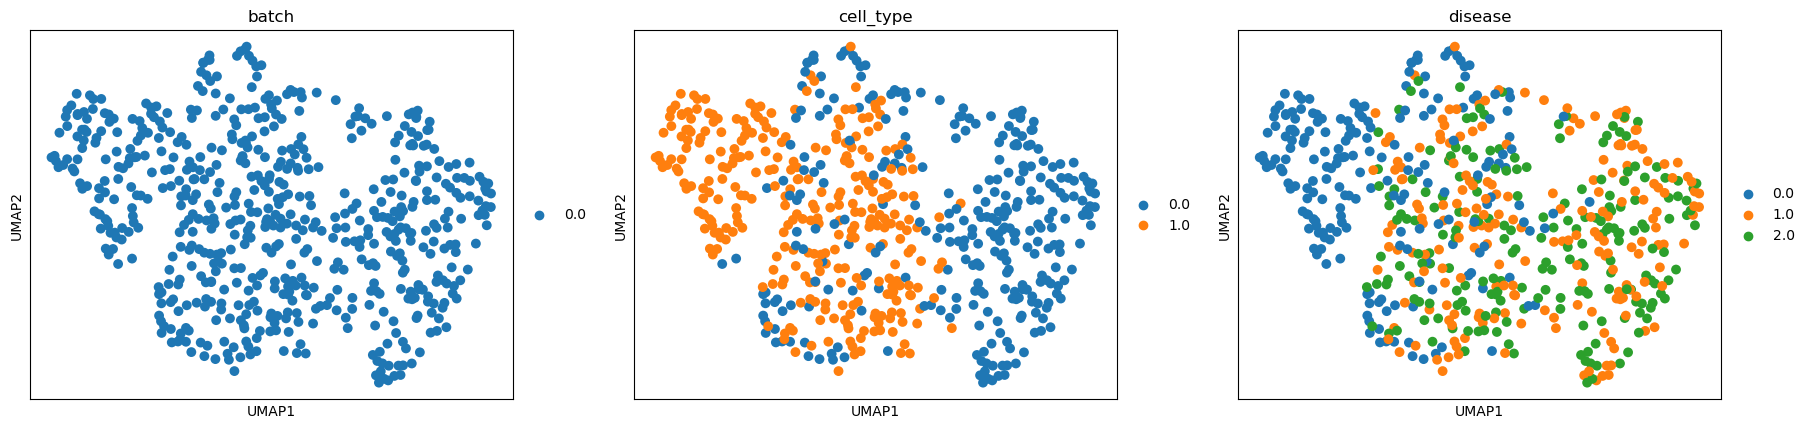

In [542]:
adata.obsm['X_FinVAE'] = model.get_latent_representation(latent_type='inv')

sc.pp.neighbors(adata, use_rep='X_FinVAE')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

In [543]:
adata.obsm['X_FinVAE_full'] = model.get_latent_representation(latent_type='full')

Using saved adata for latent representation!


# scANVI

In [534]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype(str)

In [535]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer=None,
    batch_key="batch", 
    labels_key="cell_type",
    unlabeled_category = "Unknown"
)

model = scvi.model.SCANVI(adata)

model.train()

INFO     Training for 400 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-18bbdf05-c7ca-a9f7-0896-7641c359d553/1/0]
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:24<00:00, 16.06it/s, v_num=1, train_loss_step=772, train_loss_epoch=771]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:24<00:00, 16.11it/s, v_num=1, train_loss_step=772, train_loss_epoch=771]


In [536]:
adata.obsm['X_scanvi'] = model.get_latent_representation()

In [537]:
adata.obsm['X_scanvi'].shape

(600, 10)

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


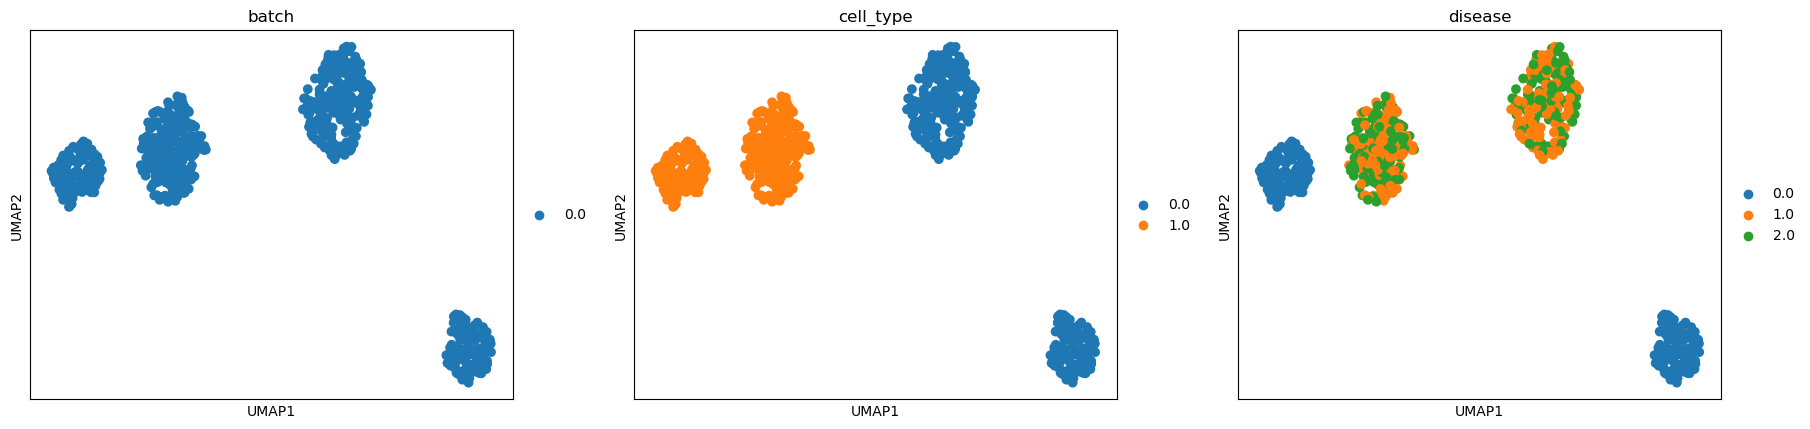

In [538]:
sc.pp.neighbors(adata, use_rep='X_scanvi')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

# Measures

In [544]:
gt_latent = adata.obsm['groundtruth_latent']

mcc_score = mcc(gt_latent, adata.obsm['X_FinVAE_full'], method='pearson')
mcc_score_spearman = mcc(gt_latent, adata.obsm['X_FinVAE_full'], method='spearman')

r2 = get_linear_score(gt_latent, adata.obsm['X_FinVAE_full'])

print(f'MCC pearson score: {mcc_score}')
print(f'MCC spearman score: {mcc_score_spearman}')
print(f'R2 score: {r2}')

MCC pearson score: 0.9297917608707664
MCC spearman score: 0.9319736443712344
R2 score: 0.9595672404669833


In [545]:
gt_latent = adata.obsm['groundtruth_latent_inv']

mcc_score = mcc(gt_latent, adata.obsm['X_scanvi'], method='pearson')
mcc_score_spearman = mcc(gt_latent, adata.obsm['X_scanvi'], method='spearman')

r2 = get_linear_score(gt_latent, adata.obsm['X_scanvi'])

print(f'MCC pearson score: {mcc_score}')
print(f'MCC spearman score: {mcc_score_spearman}')
print(f'R2 score: {r2}')

MCC pearson score: 0.8586860950712708
MCC spearman score: 0.8593711834384724
R2 score: 0.8247266349138572
